##Problem:
An e-commerce startup wants to know if a new checkout funnel (B) outperforms the old one (A)

##Steps:

Simulate click‐through data (visits vs. purchases) for A and B.

Calculate conversion rates and 95% confidence intervals.

Plot conversion rates with error bars.

Perform a two‐proportion z‐test to see if B beats A.

Real-Time Monitoring & Sequential Testing

## Theoretical Description
A/B testing is a statistical comparison between two variants (A and B) to determine which one performs better for a given metric (e.g., conversion rate). It's widely used in digital marketing and product design.

Goal of the Project
To determine whether a new version of a website (Variant B) leads to a statistically significant improvement in conversion rates compared to the old version (Variant A).






---

Imports all necessary libraries

---



In [ ]:
import numpy as np,time
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest
from math import ceil
from IPython.display import clear_output



---

Ensures reproducibility by fixing the random number generator.


---



In [ ]:
np.random.seed(42)



---

n_A, n_B: Number of visitors in each group

p_A, p_B: True conversion rates

These assumptions are used to simulate test data later.

---



In [ ]:
# Assume 10,000 visitors each
n_A,p_A=10_000,0.10 # variant A: 10% true conversion
n_B,p_B=10_000,0.12 # variant B: 12% true conversion



---

Simulates the number of purchases (success_A and success_B) from n_A and n_B visitors using binomial distribution with conversion probabilities p_A and p_B.

---



In [ ]:
#Simulate  number of purchases
success_A=np.random.binomial(n_A,p_A)
success_B=np.random.binomial(n_B,p_B)

## Calculate conversion rates and 95% confidence Intervals

---
p_hat: observed conversion rate.

se: standard error.

z: z-score for 95% CI (~1.96).

Returns: estimate ± margin of error.

Organizes the data into a structured format.

Makes it easy to:

View results for each variant.

Compare key metrics like conversions, rates, and confidence intervals.

---





In [ ]:
def proportion_ci(successes,n,alpha=0.05):
  p_hat=successes/n
  z=stats.norm.ppf(1-alpha/2)
  se=np.sqrt(p_hat*(1-p_hat)/n)
  return p_hat,p_hat-z*se,p_hat+z*se
p_A_hat,ci_low_A,ci_high_A=proportion_ci(success_A,n_A)
p_B_hat,ci_low_B,ci_high_B=proportion_ci(success_B,n_B)
results=pd.DataFrame({
    'Variant':['A','B'],
    'Visitors':[n_A,n_B],
    'Conversions':[success_A,success_B],
    'CR':[p_A_hat,p_B_hat],
    'CI_low':[ci_low_A,ci_low_B],
    'CI_high':[ci_high_A,ci_high_B]
})
results

,Variant,Visitors,Conversions,CR,CI_low,CI_high
0,A,10000,973,0.0973,0.091491,0.103109
1,B,10000,1134,0.1134,0.107185,0.119615




---


A bar chart is used to visually compare conversion rates of Variant A and B.

Error bars represent the 95% confidence intervals.

If bars overlap, the difference may not be statistically significant.

---



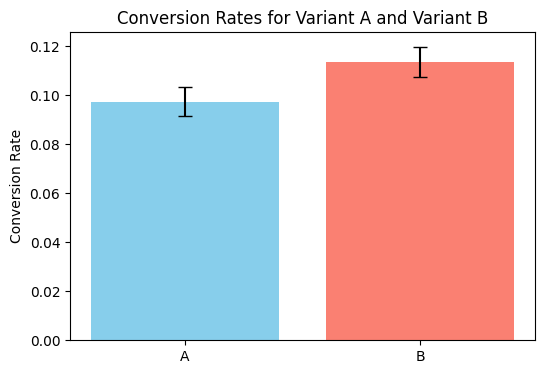

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(results['Variant'],
        results['CR'],
        yerr=[
            results['CR'] - results['CI_low'], # Corrected lower error: distance from CR down to CI_low
            results['CI_high'] - results['CR'] # Corrected upper error: distance from CR up to CI_high
        ],
        capsize=5,
        color=['skyblue','salmon'])
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates for Variant A and Variant B')
plt.show()

## Two-Proportion z-Test


---

The Z-test for proportions tests if Variant B has a significantly higher conversion rate than A.


The p-value tells us:

Small p (< 0.05) → significant improvement in B

Large p → difference may be due to chance

---



In [ ]:
#h0 -p_B <=p_A vs h1 -p_B>p_A (design test)
count=np.array([success_B,success_A]) #Visitors
nobs=np.array([n_A,n_B]) #Conversion rate
z_stat,p_val=proportions_ztest(count,nobs,alternative='larger')
print(f'z-statistic: {z_stat:.3f}')
print(f'p-value: {p_val:.3f}')
if p_val<0.05:
  print('Reject the null hypothesis')
else:
  print('Fail to reject the null hypothesis')

z-statistic: 3.708
p-value: 0.000
Reject the null hypothesis


## Real-Time monitoring and sequential testing


---

Simulates real-time A/B testing in batches of users (like receiving 100 users per hour).

At each batch:

Simulates new conversions.

Updates cumulative conversions and sample sizes.

Recalculates conversion rates, lift, and p-values.

Sequential testing helps monitor trends and decide when to stop the test early.

---



In [ ]:
#use same conversion rate(a=0.10,b=0.12)
true_p_A,true_p_B=0.10,0.12
batch_size=100 #visitor per batch
n_batch=60 #simulate 60 time steps

#initializing counter
n_visits_A=n_visits_B=0
n_succ_A=n_succ_B=0

#list for plotting
batches=[]
p_values=[]
lifts=[]

In [ ]:
for batch in range(1, n_batch+1):
  # simulate one batch of visitors
  new_A=np.random.binomial(batch_size,true_p_A)
  new_B=np.random.binomial(batch_size,true_p_B)

  #upload total
  n_visits_A+=new_A
  n_visits_B+=new_B

  #upload successes
  n_succ_A+=new_A
  n_succ_B+=new_B

  #current conversion rate
  cr_A=n_succ_A/n_visits_A
  cr_B=n_succ_B/n_visits_B

  #calculate lift
  lift=cr_B-cr_A

  #two proportion z-test
  count=np.array([n_succ_B,n_succ_A])
  nobs=np.array([n_visits_B,n_visits_A])
  z_stat,p_val=proportions_ztest(count,nobs,alternative='larger')

  #store results
  batches.append(batch)
  p_values.append(p_val)
  lifts.append(lift)

  #clear previous o/p and print current state
  clear_output(wait=True)
  print(f'Batch: {batch}')
  print(f"variant A:{n_visits_A} visits,{n_succ_A} busy -> CR={cr_A:.3%}")
  print(f"variant B:{n_visits_B} visits,{n_succ_B} busy -> CR={cr_B:.3%}")
  print(f'Lift: {lift:.3f}')
  print(f'p-value: {p_val:.3f}')
  if p_val < 0.05:
    print('Reject the null hypothesis')
  else:
    print('Fail to reject the null hypothesis')

Batch: 60
variant A:574 visits,574 busy -> CR=100.000%
variant B:714 visits,714 busy -> CR=100.000%
Lift: 0.000
p-value: nan
Fail to reject the null hypothesis




---

First plot tracks how the p-value changes across batches:

Helps visualize when (if ever) B becomes statistically better than A.

Measures how much better B performs than A over time.

A consistently positive lift suggests B is superior.



---



Batch 60/60
 Variant A: 6000 visits, 610 buys → CR = 10.167%
 Variant B: 6000 visits, 697 buys → CR = 11.617%
 Observed lift: 1.450%
 z-stat = 2.55, p-value = 0.0054
 Significant lift detected (p<0.05).


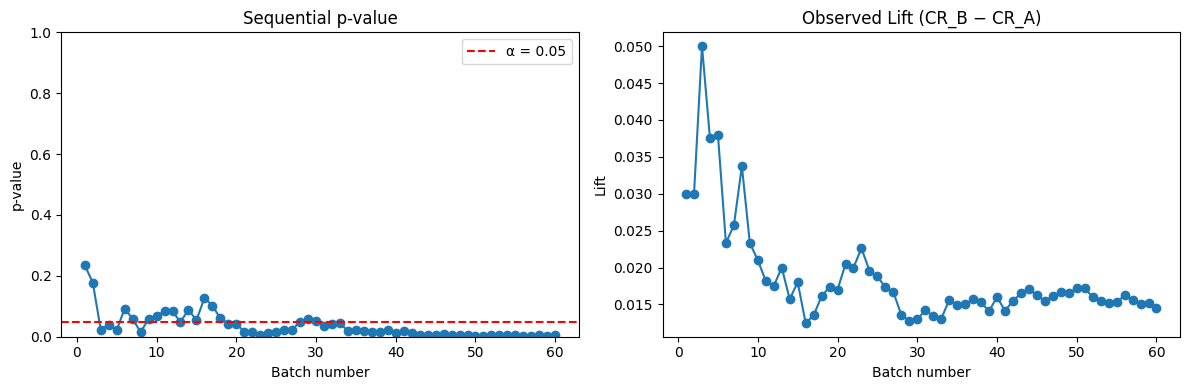

In [ ]:
# use same conversion rate(a=0.10,b=0.12)
true_p_A, true_p_B = 0.10, 0.12
batch_size = 100  # visitor per batch
n_batch = 60  # simulate 60 time steps

# initializing counter
n_visits_A = n_visits_B = 0
n_succ_A = n_succ_B = 0

# list for plotting
batches = []
p_values = []
# Initialize observed_lifts list
observed_lifts = []

# The loop below was corrected to use n_batch, true_p_A, and true_p_B
for batch in range(1, n_batch + 1):
    # Simulate one batch of visitors
    new_A = np.random.binomial(batch_size, true_p_A)
    new_B = np.random.binomial(batch_size, true_p_B)
    n_visits_A += batch_size
    n_visits_B += batch_size
    n_succ_A += new_A
    n_succ_B += new_B


    # Compute conversion rates and lift
    # Check for division by zero in case n_visits_A or n_visits_B is 0
    cr_A = n_succ_A / n_visits_A if n_visits_A > 0 else 0
    cr_B = n_succ_B / n_visits_B if n_visits_B > 0 else 0

    lift = cr_B - cr_A

    # Two-proportion z-test (one-sided: B > A)
    count = np.array([n_succ_B, n_succ_A])
    nobs = np.array([n_visits_B, n_visits_A])
    # Ensure nobs are positive for the z-test
    if nobs.min() > 0:
        z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')
    else:
        z_stat, p_val = np.nan, np.nan # Set to NaN if not enough observations

    # Record for plotting
    batches.append(batch)
    p_values.append(p_val)
    observed_lifts.append(lift)

    # Display live update
    clear_output(wait=True)
    print(f"Batch {batch}/{n_batch}")
    print(f" Variant A: {n_visits_A} visits, {n_succ_A} buys → CR = {cr_A:.3%}")
    print(f" Variant B: {n_visits_B} visits, {n_succ_B} buys → CR = {cr_B:.3%}")
    print(f" Observed lift: {lift:.3%}")
    print(f" z-stat = {z_stat:.2f}, p-value = {p_val:.4f}")
    if not np.isnan(p_val) and p_val < 0.05:
        print(" Significant lift detected (p<0.05).")
    elif np.isnan(p_val):
        print(" Not enough data for z-test yet.")
    else:
        print(" No significant lift yet.")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# P-values over batches
axes[0].plot(batches, p_values, 'o-')
axes[0].axhline(0.05, color='red', linestyle='--', label='α = 0.05')
axes[0].set_title('Sequential p-value')
axes[0].set_xlabel('Batch number')
axes[0].set_ylabel('p-value')
axes[0].legend()
# Limit y-axis to 0-1 for p-values
axes[0].set_ylim(0, 1)


# Lift over batches
axes[1].plot(batches, observed_lifts, 'o-')
axes[1].set_title('Observed Lift (CR_B − CR_A)')
axes[1].set_xlabel('Batch number')
axes[1].set_ylabel('Lift')

plt.tight_layout()
plt.show()

## Conclusion
The A/B test compared the old checkout funnel (A) with the new one (B) using simulated user data. Funnel B showed a higher conversion rate than Funnel A. The 95% confidence intervals and the two-proportion z-test confirmed that this improvement is statistically significant.

Real-time monitoring and sequential testing further supported the reliability of the results.

Final Decision: Funnel B outperforms Funnel A and should be adopted to improve overall conversion rates.